In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
from PIL import Image
import random
import os



In [4]:
random.seed(0)
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])


,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


In [6]:


#Structure and Size
print("Main Data Shape: " + str(data_main.shape))
print("Extra Data Shape: " + str(data_extra.shape))
print("Common Columns: ")

for column in data_main.columns.intersection(data_extra.columns):
    print("      "+ column)
print("Unique Main Columns: ")
for column in data_main.columns.symmetric_difference(data_extra.columns):
    print("      "+ column)

print("Null Main Data: " + str(data_main.isnull().sum()))
print("Duplicated Main Data: " + str(data_main.duplicated().sum()))
print("Images Duplicated:  " + str(data_main["ImageName"].duplicated().sum()))




Main Data Shape: (9896, 6)
Extra Data Shape: (10384, 4)
Common Columns: 
      InstanceID
      patientID
      ImageName
      isCancerous
Unique Main Columns: 
      cellType
      cellTypeName
Null Main Data: InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Duplicated Main Data: 0
Images Duplicated:  0


**Shape and Size:** Before analysis, we needed to find out the dimensionality of both datasets. Consistent structure was required if we wanted to use both datasets to train a single model. We found that data_labels_mainData.csv had a shape of (9896, 6), while data_labels_extraData.csv had a shape of only (10384, 4). Both shared four common columns: “InstanceID”, “PatientID”, “ImageName” and “isCancerous”, with the main data including two additional columns “cellType” and “cellTypeName” which had a one-to-one correlation. 

**Column Interpretation:** In order to understand the dataset, it was important for us to identify any obvious relationships based on a column's data type and their values. For example, the column “InstanceID” is clearly just a unique reference for each item in the dataset, its value should not have any influence over the results. By analysing each column in this manner, we would more easily be able to identify which features would be valuable in our models. 

Value counts for Iscancerous
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Percent size: 
0: 58.78132578819725
1: 41.21867421180275


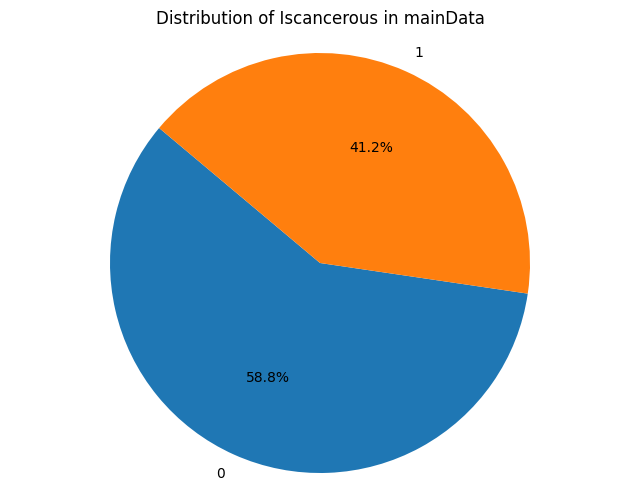

Value counts for Celltypename
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Percent size: 
Epithelial: 41.21867421180275
Inflammatory: 25.697251414713012
Fibroblast: 19.078415521422798
Others: 14.005658852061439


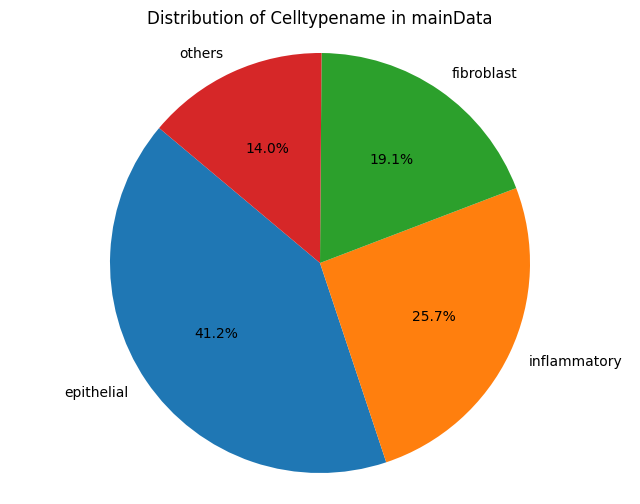

isCancerous
0    7394
1    2990
Name: count, dtype: int64
Percent size: 
0: 71.20570107858244
1: 28.794298921417568


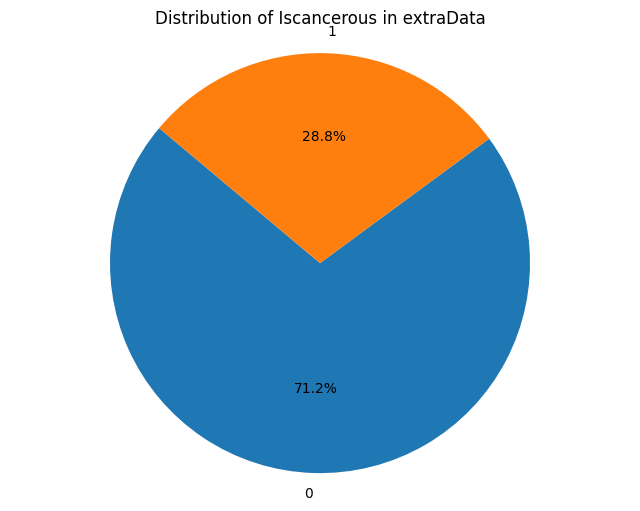

0: 65.1429980276134
1: 34.857001972386584


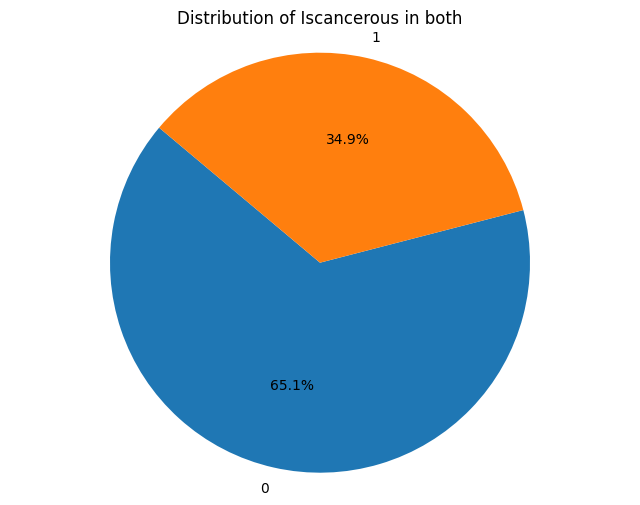

In [12]:
#Value Counts
relevantColumns = ["isCancerous", "cellTypeName"]
for col in relevantColumns:
    print(f"Value counts for " + col.capitalize())
    value_counts = data_main[col].value_counts()
    print(value_counts)
    print("Percent size: " )
    
    for value, amount in data_main[col].value_counts().items():
        print(str(value).capitalize() + ": " + str((amount/len(data_main[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()} in mainData")
    plt.axis('equal')  
    plt.show()

col = "isCancerous"
value_counts = data_extra[col].value_counts()
print(value_counts)
print("Percent size: " )

for value, amount in data_extra[col].value_counts().items():
    print(str(value).capitalize() + ": " + str((amount/len(data_extra[col]))*100))

plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f"Distribution of {col.capitalize()} in extraData")
plt.axis('equal')  
plt.show()
combined = pd.concat([data_extra, data_main])
value_counts = combined[col].value_counts()

for value, amount in combined[col].value_counts().items():
    print(str(value).capitalize() + ": " + str((amount/len(combined[col]))*100))

plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f"Distribution of {col.capitalize()} in both")
plt.axis('equal')  
plt.show()


**Data Distribution:** Understanding the distribution of values for both columns “IsCancerous” and “CellTypeName” would be a great indicator whether or not we would need to manipulate our data before passing it through the model. We found that in our mainData, the proportion of isCancerous to not isCancerous was ~0.41:0.59. The difference between the two values was minimal enough that we should not need to augment any data. However, in the extra data, the proportion was skewed with (71.2%) being labelled as non-cancerous. When we combine both datasets we found that the overall percentage was 65.1% - 34.9% noncancerous - cancerous. 
	We also found it could be valuable to do the same check for the cell type, and our results were quite concerning. Out of all the cells in our main data, 41.2% of them were labelled epithelial, 25.7% inflammatory, 19.1% fibroblast and 14.0% others. This large proportion of epithelial cells could very well cause our classification model to overwhelmingly bias marking cells as epithelial. Our solution to this was data augmentation.  


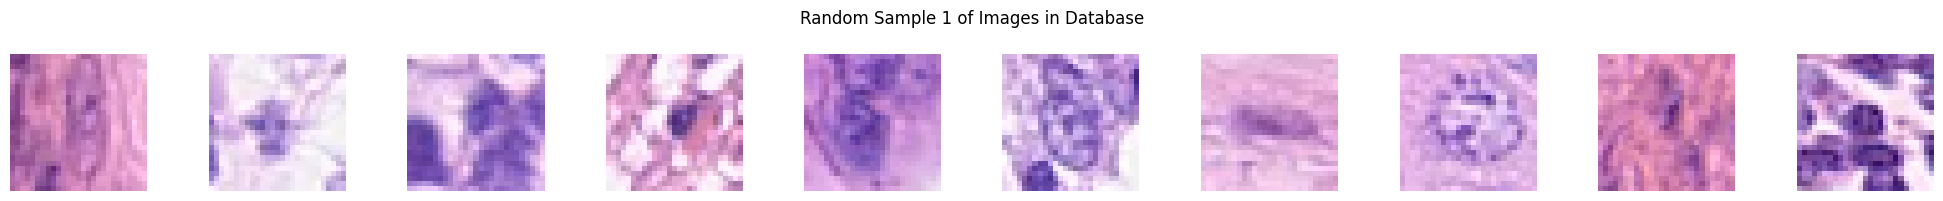

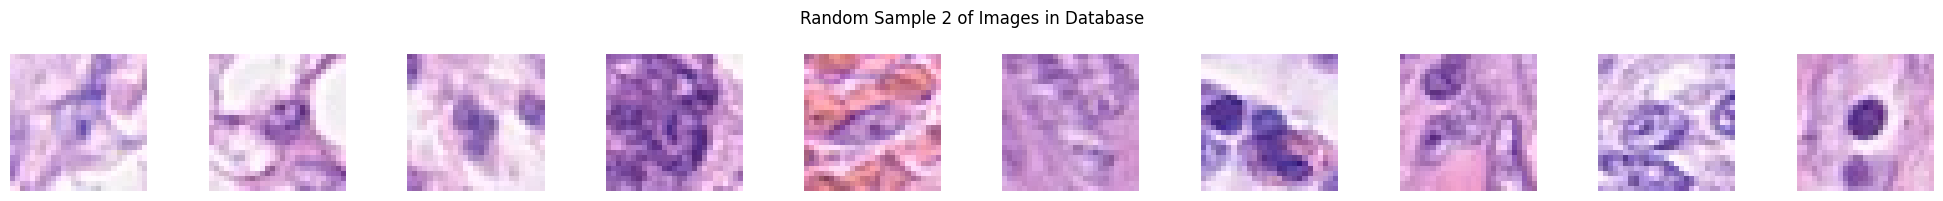

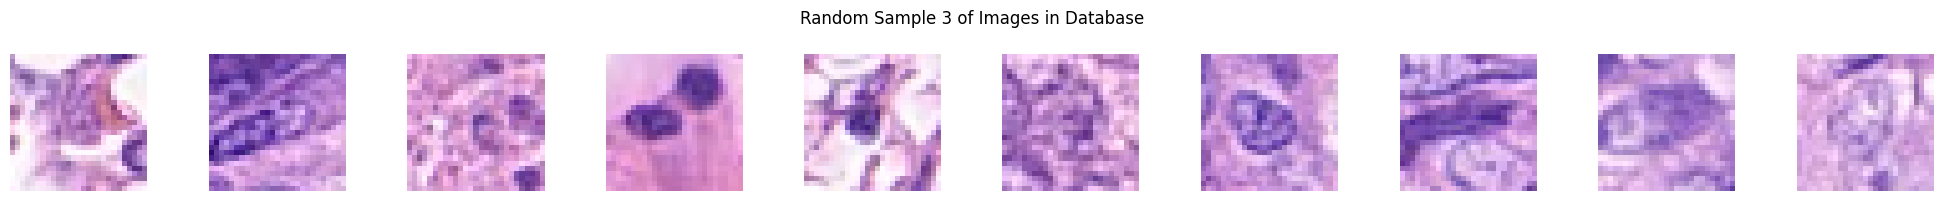

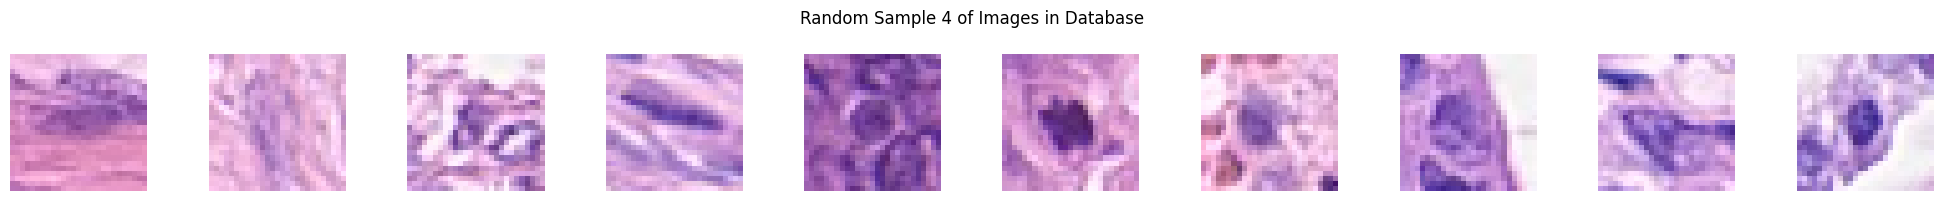

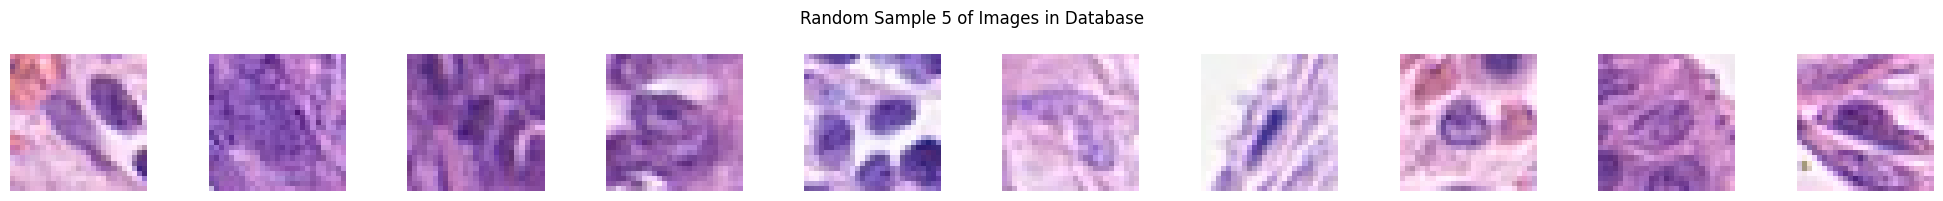

In [13]:

#Random Sampling
dir = "./patch_images/" 
for i in range(1, 6):
    fig, axes = plt.subplots(1, 10, figsize=(20,2))
    fig.suptitle("Random Sample " + str(i) + " of Images in Database")
    sampledRows = data_main.sample(10)
    for j, ax in enumerate(axes):
        image_name = sampledRows.iloc[j]["ImageName"]
        img = np.asarray(Image.open(dir + image_name))
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()



**Data Samples:** In order to see if there were any artifacts present in the dataset, we sampled 50 random images in the dataset and analysed them. There were no signs of occlusion, embedded text or blur. However, as the image sizes are very small, discrepancies like blur would be less noticeable. 
**Feature Selection:** To make sure our models only used relevant data, we came to the conclusion that only the image, isCancerous and CellType columns would be included. The others (while may increase accuracy in this dataset) may lead to overfitting when introduced on unique data. 


In [135]:
def AugmentData(imageNames, maxCount, originalDF, label, labelName, augmentedCSV):


    dir = "./patch_images/"
    augmentedRows = []

    # Find all existing augmented images for this label
    existing_aug = [
        name for name in os.listdir(dir)
        if name.startswith(f"Augmented_{label}_") and name.endswith(".png")
    ]
    existing_aug_count = len(existing_aug)
    original_count = len(imageNames)

    total_existing = original_count + existing_aug_count
    print(f"Files detected for '{labelName}': {total_existing}, Max Count: {maxCount}")

    # Check how many more images we need
    if total_existing >= maxCount:
        return pd.DataFrame()  # Nothing to augment

    target = maxCount - total_existing
    print(f"Generating {target} new augmented images for '{labelName}'...")

    for i in range(target):
        # Pick a random original image
        chosenImage = random.choice(imageNames)
        openedImage = PIL.Image.open(os.path.join(dir, chosenImage)).convert("RGB")

        # Convert to tensor
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)

        # Apply augmentation
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
        ])
        augmented_tensor = data_augmentation(image_tensor)
        augmented_image = tf.cast(tf.squeeze(augmented_tensor), tf.uint8).numpy()
        augmented_pil = PIL.Image.fromarray(augmented_image)

        # Save augmented image
        new_id = existing_aug_count + i + 1
        augmentedImageName = f"Augmented_{label}_{new_id}.png"
        save_path = os.path.join(dir, augmentedImageName)
        augmented_pil.save(save_path)

        # Append to new CSV row
        new_row = {
            "ImageName": augmentedImageName,
            "cellType": label,
            "cellTypeName": labelName
        }
        augmentedRows.append(new_row)

    # Save to CSV
    new_df = pd.DataFrame(augmentedRows)
    if os.path.exists(augmentedCSV):
        new_df.to_csv(augmentedCSV, mode='a', header=False, index=False)
    else:
        new_df.to_csv(augmentedCSV, index=False)

    return new_df

In [136]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

IMG_SIZE = 27
cell_type_counts = data_main["cellType"].value_counts().sort_index()
most_common_cell_type = cell_type_counts.idxmax()
print(most_common_cell_type)
max_value = cell_type_counts.max()
print(max_value)

cell_type_mapping = data_main.drop_duplicates(subset=["cellType"])[["cellType", "cellTypeName"]].sort_values("cellType")
cell_type_names = cell_type_mapping["cellTypeName"].values
cell_type_dict = dict(zip(cell_type_mapping["cellType"], cell_type_mapping["cellTypeName"]))
print(cell_type_dict)


cellType0Images = data_main[data_main["cellType"] == 0]["ImageName"].values
cellType1Images = data_main[data_main["cellType"] == 1]["ImageName"].values
cellType2Images = data_main[data_main["cellType"] == 2]["ImageName"].values
cellType3Images = data_main[data_main["cellType"] == 3]["ImageName"].values

imageCollections = []
imageCollections.append(cellType0Images)
imageCollections.append(cellType1Images)
imageCollections.append(cellType2Images)
imageCollections.append(cellType3Images)

data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
data_type_with_augmentation = data_type.copy()
cell_types_to_generate = cell_type_dict.copy()
del cell_types_to_generate[most_common_cell_type]

dir = "./patch_images/"
augmentedCSV = "augmented_data.csv"
# Remove augmented CSV (if you want a fresh count)
# if os.path.exists(augmentedCSV):
#     os.remove(augmentedCSV)

# Always create the CSV, even if it's empty
# pd.DataFrame(columns=["ImageName", "cellType", "cellTypeName"]).to_csv(augmentedCSV, index=False)

# # Optionally: delete all augmented images from patch_images/
# for cellType in cell_type_dict.keys():
#     for file in os.listdir(dir):
#         if file.startswith(f"Augmented_{cellType}_") and file.endswith(".png"):
#             os.remove(os.path.join(dir, file))

for cellType in cell_types_to_generate:
    cellTypeName = cell_type_dict[cellType]

    # Count already augmented images for this cell type (based on naming convention)
    existing_aug = [
        name for name in os.listdir(dir)
        if name.startswith(f"Augmented_{cellType}_") and name.endswith(".png")
    ]
    total_images = len(existing_aug) + len(imageCollections[cellType])

    print(f"Current total for {cellTypeName}: {total_images}, Target: {max_value}")

    if total_images < max_value:
        augmented_df = AugmentData(
            imageCollections[cellType],
            max_value,
            data_type,
            cellType,
            cellTypeName,
            augmentedCSV
        )
        data_type_with_augmentation = pd.concat([data_type_with_augmentation, augmented_df], ignore_index=True)

# Final steps: Read and format augmented CSV
augmentedData = pd.read_csv(augmentedCSV, header=None, names=["ImageName", "cellType", "cellTypeName"])
augmentedData["InstanceID"] = np.nan
augmentedData["patientID"] = np.nan
augmentedData["isCancerous"] = 0  # Or NaN if unsure

# Match column order
augmentedData = augmentedData[data_main.columns]

# Merge into the main dataframe
mainDataWithAugments = pd.concat([data_main, augmentedData], ignore_index=True)
mainDataWithAugments = mainDataWithAugments[mainDataWithAugments["cellTypeName"] != "cellTypeName"]
print(data_main)
print(augmentedData)
print(mainDataWithAugments)


2
4079
{0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}
Current total for fibroblast: 4079, Target: 4079
Current total for inflammatory: 4079, Target: 4079
Current total for others: 4079, Target: 4079
      InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.png   fibroblast         0            0
1          22406          1  22406.png   fibroblast         0            0
2          22407          1  22407.png   fibroblast         0            0
3          22408          1  22408.png   fibroblast         0            0
4          22409          1  22409.png   fibroblast         0            0
...          ...        ...        ...          ...       ...          ...
9891        1625         60   1625.png   epithelial         2            1
9892        1626         60   1626.png   epithelial         2            1
9893        1627         60   1627.png   epithelial         2            1
9894        1628         60   1

**Data augmentation:** Our data augmentation algorithm works by randomly generating new samples from each cellType until the distribution is equal. These newly generated images are then added to our database and used in the training of the classification models. 


(16316, 6)
(9896, 6)
(6421, 6)
97902
Value counts for Celltypename
cellTypeName
fibroblast      4079
inflammatory    4079
others          4079
epithelial      4079
Name: count, dtype: int64
Percent size: 
Fibroblast: 25.0
Inflammatory: 25.0
Others: 25.0
Epithelial: 25.0


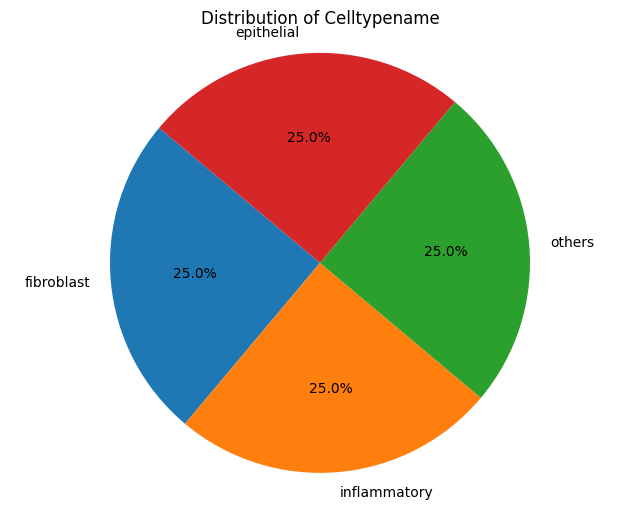

In [137]:
print(mainDataWithAugments.shape)
print(data_main.shape)
print(augmentedData.shape)
print(data_main.size + augmentedData.size)

col = "cellTypeName"
print(f"Value counts for " + col.capitalize())
value_counts = mainDataWithAugments[col].value_counts()
print(value_counts)
print("Percent size: " )

for value, amount in mainDataWithAugments[col].value_counts().items():
    print(str(value).capitalize() + ": " + str((amount/len(mainDataWithAugments[col]))*100))

plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f"Distribution of {col.capitalize()}")
plt.axis('equal')  
plt.show()

In [138]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [139]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [140]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='min', restore_best_weights=True)

In [141]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [142]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [143]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


**MLP**

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - categorical_accuracy: 0.6729 - loss: 0.5971 - val_categorical_accuracy: 0.7756 - val_loss: 0.4797
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7894 - loss: 0.4738 - val_categorical_accuracy: 0.7628 - val_loss: 0.4505
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8166 - loss: 0.4176 - val_categorical_accuracy: 0.8499 - val_loss: 0.3752
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.8290 - loss: 0.3885 - val_categorical_accuracy: 0.8437 - val_loss: 0.3625
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8299 - loss: 0.3697 - val_categorical_accuracy: 0.8146 - val_loss: 0.4117
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8350 - loss: 0.3704 - val_categorical_accuracy: 0.8341 - val_loss: 0.3711
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8424 - loss: 0.3607

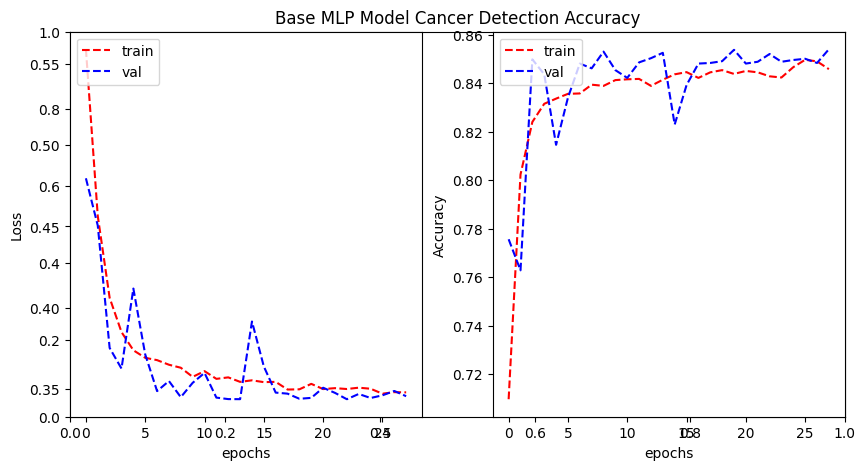

In [15]:
plot_learning_curve("Base MLP Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [16]:
model.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 974us/step - categorical_accuracy: 0.8470 - loss: 0.3403


[0.3455974757671356, 0.848372757434845]

We created a baseline MLP model very similar to the one used in the workshop in class. It uses a single hidden layer of 256 neurons and a sigmoid activation function, with the output layer having 2 neurons. The results are decent with 34% loss and 84% accuracy, but this can definitely be improved

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [19]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.6788 - loss: 0.6289 - val_categorical_accuracy: 0.8499 - val_loss: 0.3867
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7917 - loss: 0.4412 - val_categorical_accuracy: 0.8269 - val_loss: 0.3819
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8241 - loss: 0.3876 - val_categorical_accuracy: 0.8358 - val_loss: 0.3687
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8288 - loss: 0.3810 - val_categorical_accuracy: 0.8397 - val_loss: 0.3667
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8241 - loss: 0.3852 - val_categorical_accuracy: 0.8385 - val_loss: 0.3581
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8374 - loss: 0.3631 - val_categorical_accuracy: 0.8454 - val_loss: 0.3599
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.835

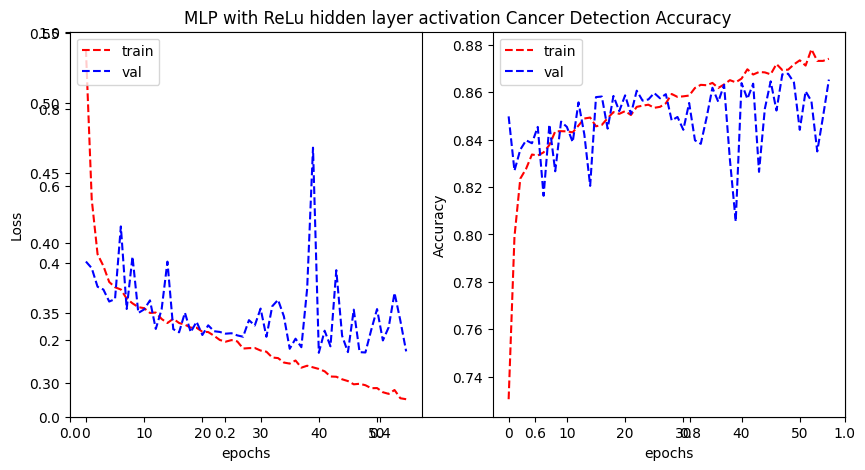

In [20]:
plot_learning_curve("MLP with ReLu hidden layer activation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [21]:
model.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 881us/step - categorical_accuracy: 0.8735 - loss: 0.3016


[0.31625860929489136, 0.8663707971572876]

This model is definitely improved, but there is a lot more variance between epoch,s which leads to a much less smooth graph, however the trend is still clear enough to show the model improving over more epochs, reaching around 31% loss and 86% accuracy. We can have an activation for the output layer and use a single neuron. To do this, we need to alter the data generators to be binary instead of categorical. 

In [22]:

batch_size = 27

train_generator_binary = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator_binary = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [23]:
earlyStopBinary = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='min', restore_best_weights=True)

In [24]:
batch_size = 1

test_generator_binary = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 4056 validated image filenames belonging to 2 classes.


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6923 - loss: 0.5998 - val_accuracy: 0.8286 - val_loss: 0.3932
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8019 - loss: 0.4274 - val_accuracy: 0.7991 - val_loss: 0.4283
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8176 - loss: 0.3983 - val_accuracy: 0.8474 - val_loss: 0.3560
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8274 - loss: 0.3845 - val_accuracy: 0.8538 - val_loss: 0.3468
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8329 - loss: 0.3748 - val_accuracy: 0.8540 - val_loss: 0.3456
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8400 - loss: 0.3570 - val_accuracy: 0.8518 - val_loss: 0.3496
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8360 - loss: 0.3607 - val_accuracy: 0.8511 - val_loss: 0.3478
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8362 - loss: 0.3675 - val_accuracy: 0.8489

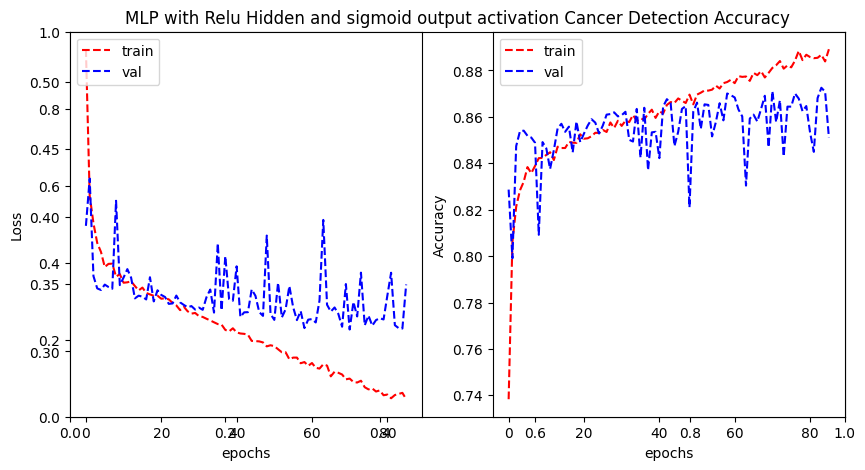

In [28]:
plot_learning_curve("MLP with Relu Hidden and sigmoid output activation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [29]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 3s 855us/step - accuracy: 0.8717 - loss: 0.3085


[0.3053964674472809, 0.8740137815475464]

This model so far, is noticeably improved but takes longer to train with the initial accuracy and loss being bad, however it does continue to climb further over more epochs, leading to around 1-2% more accuracy and less loss

In [ ]:
model_best = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model_best.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model_best.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6976 - loss: 0.5699 - val_accuracy: 0.7944 - val_loss: 0.4530
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7913 - loss: 0.4463 - val_accuracy: 0.8018 - val_loss: 0.4267
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8089 - loss: 0.4130 - val_accuracy: 0.8092 - val_loss: 0.4095
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8264 - loss: 0.3857 - val_accuracy: 0.8484 - val_loss: 0.3557
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8378 - loss: 0.3724 - val_accuracy: 0.8274 - val_loss: 0.3795
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8321 - loss: 0.3704 - val_accuracy: 0.8484 - val_loss: 0.3529
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8374 - loss: 0.3645 - val_accuracy: 0.8437 - val_loss: 0.3571
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8448 - loss: 0.3549 - val_

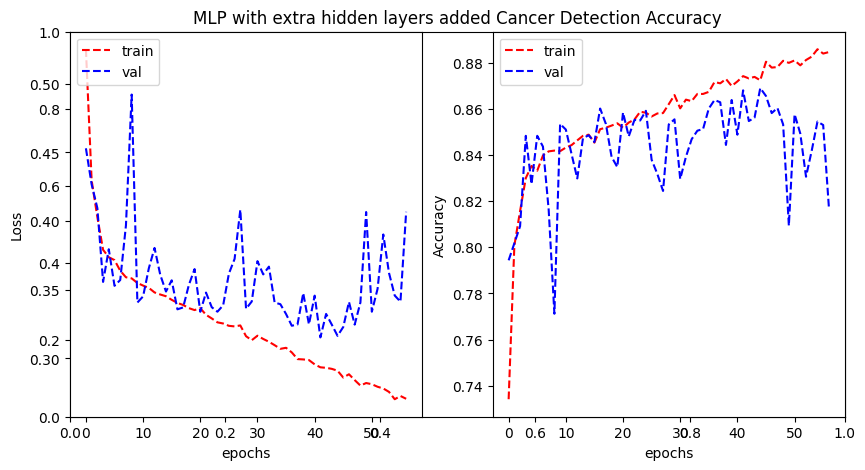

In [33]:
plot_learning_curve("MLP with extra hidden layers added Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_best.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 923us/step - accuracy: 0.8721 - loss: 0.3119


[0.3080088198184967, 0.8725345134735107]

This one had marginal differences in results, which is within margin of error however, it converged on these values a little quicker, which is interesting as the model is more complex

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8597 - loss: 0.3142 - val_accuracy: 0.8558 - val_loss: 0.3385
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8642 - loss: 0.3201 - val_accuracy: 0.8459 - val_loss: 0.3548
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8697 - loss: 0.3110 - val_accuracy: 0.8565 - val_loss: 0.3430
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8653 - loss: 0.3101 - val_accuracy: 0.8592 - val_loss: 0.3330
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8586 - loss: 0.3179 - val_accuracy: 0.8642 - val_loss: 0.3278
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8678 - loss: 0.3040 - val_accuracy: 0.8558 - val_loss: 0.3572
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8596 - loss: 0.3155 - val_accuracy: 0.8356 - val_loss: 0.3852
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8671 - loss: 0.3091 - 

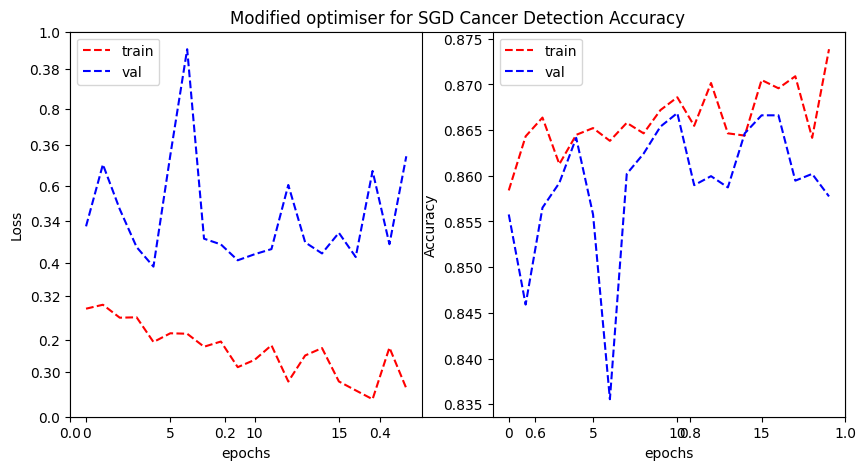

In [ ]:
plot_learning_curve("Modified optimiser for SGD Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [40]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 946us/step - accuracy: 0.8653 - loss: 0.3218


[0.31602734327316284, 0.8661242723464966]

This seems to negatively affect the model, so we will not be continuing to use it, we can try using the adam optimiser, but we may be nearing the limit of the MLP model

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [42]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6995 - loss: 0.5927 - val_accuracy: 0.8503 - val_loss: 0.3569
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8183 - loss: 0.4020 - val_accuracy: 0.8511 - val_loss: 0.3479
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8318 - loss: 0.3771 - val_accuracy: 0.8484 - val_loss: 0.3536
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8315 - loss: 0.3829 - val_accuracy: 0.8262 - val_loss: 0.3801
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8318 - loss: 0.3769 - val_accuracy: 0.8210 - val_loss: 0.3877
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8372 - loss: 0.3759 - val_accuracy: 0.8538 - val_loss: 0.3455
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8293 - loss: 0.3692 - val_accuracy: 0.8508 - val_loss: 0.3481
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8397 - loss: 0.3604 - 

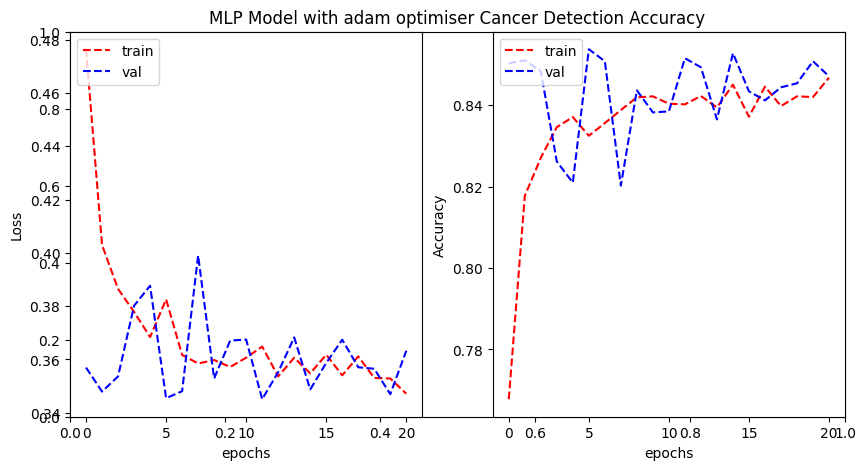

In [44]:
plot_learning_curve("MLP Model with adam optimiser Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [45]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 937us/step - accuracy: 0.8586 - loss: 0.3409


[0.3459257483482361, 0.8523175716400146]

The accuracy and loss for this one was all over the place with the best accuracy was sitting at ~85% but the loss was sigificantly higher than the previous few models so from all this the optimal model was the extra hidden layers but before we started to alter the optimiser. As the current best model had the issue of overfitting we can use regularisation to try to combat this

In [49]:
from tensorflow.keras import regularizers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6927 - loss: 1.9145 - val_accuracy: 0.8432 - val_loss: 1.7124
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8016 - loss: 1.7506 - val_accuracy: 0.7347 - val_loss: 1.8334
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8257 - loss: 1.6908 - val_accuracy: 0.6886 - val_loss: 1.9021
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8207 - loss: 1.6629 - val_accuracy: 0.8454 - val_loss: 1.6086
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8315 - loss: 1.6289 - val_accuracy: 0.8543 - val_loss: 1.5743
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8358 - loss: 1.5950 - val_accuracy: 0.8107 - val_loss: 1.6205
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8383 - loss: 1.5658 - val_accuracy: 0.8146 - val_loss: 1.5817
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8374 - loss: 1.5481 - 

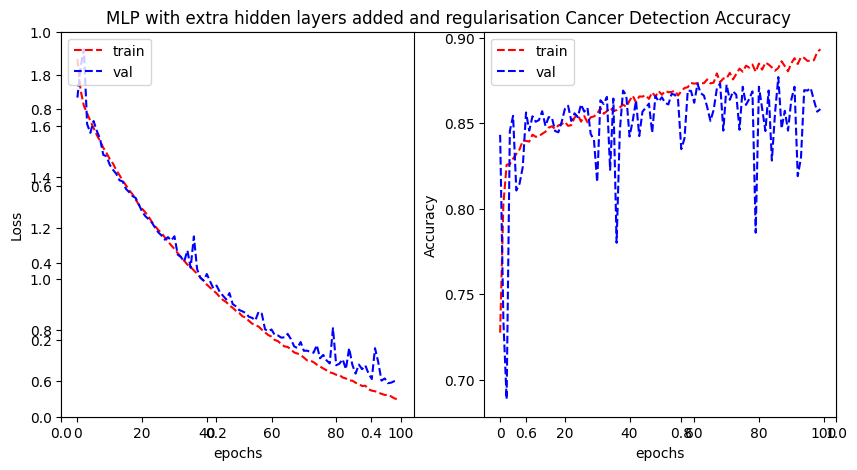

In [54]:
plot_learning_curve("MLP with extra hidden layers added and regularisation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [53]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 986us/step - accuracy: 0.8735 - loss: 0.5758


[0.5855534076690674, 0.8685897588729858]

The loss was dropping for this one, and the overfitting was reduced however even after a full 100 epochs, it still was not as good as the model without regularisation so it is not worth it even if it will eventually be better because of how much longer it takes to train for not even a guarantee of improvement

It seems like ~87% accuracy with ~30% loss is about as good as the MLP model is going to get for the cancer detection problem which is better than the ~84% accuracy and ~35% loss from the initial model however there just is not very much room for growth without moving to a CNN

**CNN**

In [55]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_VGG_cancerous.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [57]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - categorical_accuracy: 0.6360 - loss: 0.6741 - val_categorical_accuracy: 0.6573 - val_loss: 0.6484
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.6467 - loss: 0.6558 - val_categorical_accuracy: 0.6573 - val_loss: 0.6396
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.7214 - loss: 0.5427 - val_categorical_accuracy: 0.8410 - val_loss: 0.3695
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.8376 - loss: 0.3754 - val_categorical_accuracy: 0.8282 - val_loss: 0.4005
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8574 - loss: 0.3383 - val_categorical_accuracy: 0.8459 - val_loss: 0.3707
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8729 - loss: 0.3029 - val_categorical_accuracy: 0.8725 - val_loss: 0.3006
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy

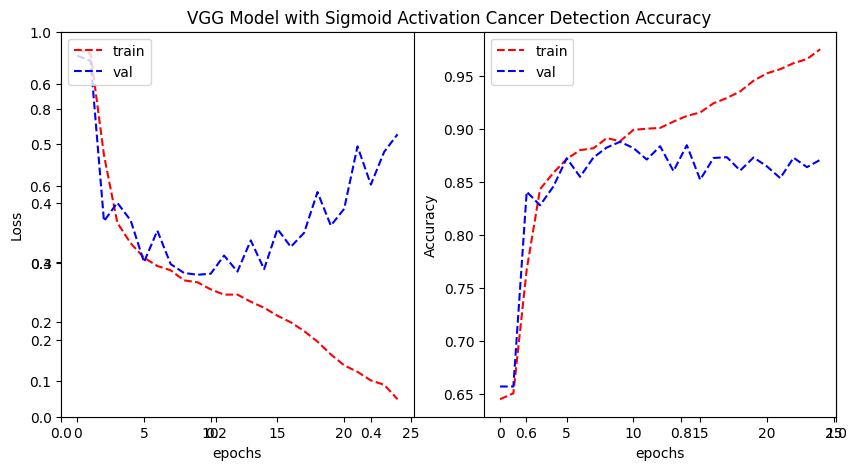

In [58]:
plot_learning_curve("VGG Model with Sigmoid Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

After doing some research, using sigmoid for the hidden layers can lead to both significant underfitting and overfitting which is exactly what this looks like (sometimes it looks like underfitting sometimes it looks like overfitting)

In [59]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [61]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - categorical_accuracy: 0.7321 - loss: 0.5178 - val_categorical_accuracy: 0.8600 - val_loss: 0.3306
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8492 - loss: 0.3479 - val_categorical_accuracy: 0.8752 - val_loss: 0.3021
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8724 - loss: 0.3059 - val_categorical_accuracy: 0.8807 - val_loss: 0.2830
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8852 - loss: 0.2901 - val_categorical_accuracy: 0.8834 - val_loss: 0.2837
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8928 - loss: 0.2728 - val_categorical_accuracy: 0.8814 - val_loss: 0.2829
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8886 - loss: 0.2747 - val_categorical_accuracy: 0.8681 - val_loss: 0.3180
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy

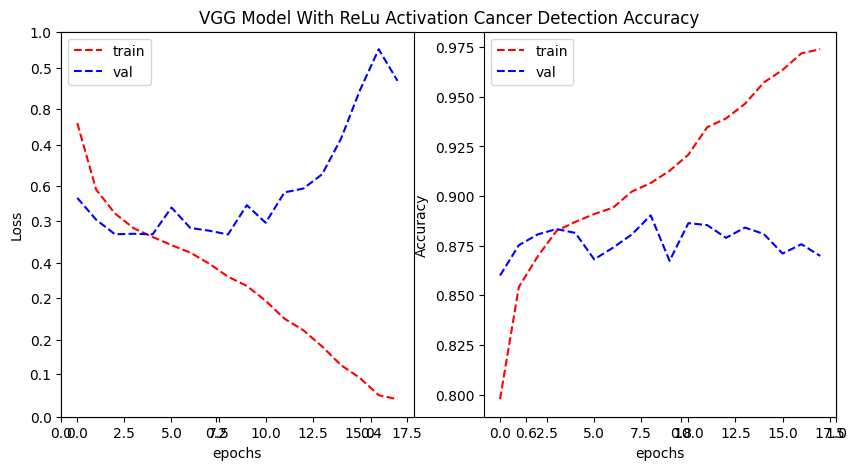

In [62]:
plot_learning_curve("VGG Model With ReLu Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [63]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.8765 - loss: 0.2859


[0.2762773931026459, 0.8841223120689392]

Now it is clearly overfitting consistently so we can start by simplifying the model as the images are relatively simple in comparison to other images neural networks are used to classify

In [64]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [66]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7607 - loss: 0.4813 - val_categorical_accuracy: 0.8629 - val_loss: 0.3283
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8575 - loss: 0.3382 - val_categorical_accuracy: 0.8767 - val_loss: 0.2969
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8730 - loss: 0.3081 - val_categorical_accuracy: 0.8728 - val_loss: 0.3035
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8745 - loss: 0.2945 - val_categorical_accuracy: 0.8681 - val_loss: 0.3181
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8813 - loss: 0.2819 - val_categorical_accuracy: 0.8777 - val_loss: 0.2851
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8906 - loss: 0.2688 - val_categorical_accuracy: 0.8908 - val_loss: 0.2644
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy

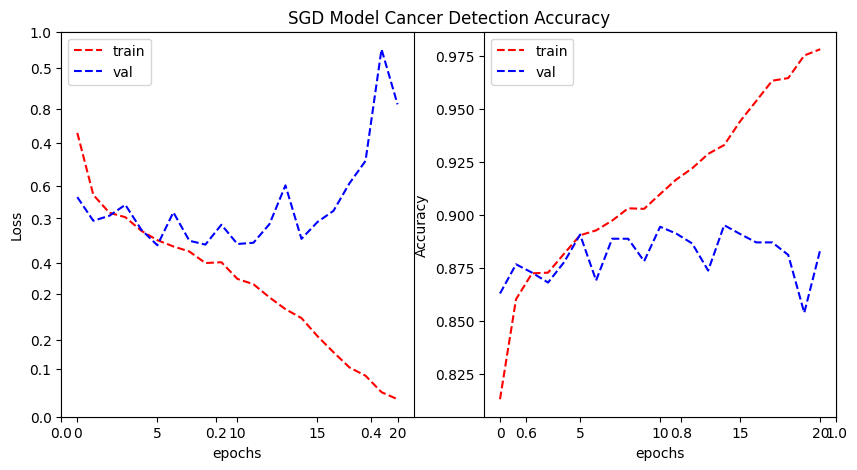

In [67]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [68]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.8999 - loss: 0.2505


[0.2505832612514496, 0.8976824283599854]

The model is still overfitting but less so, now we can try regularisation

In [ ]:

model_VGG_cancerous_best = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous_best.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_vgg_cancerous = model_VGG_cancerous_best.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7307 - loss: 0.6315 - val_categorical_accuracy: 0.8619 - val_loss: 0.3794
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - categorical_accuracy: 0.8509 - loss: 0.3990 - val_categorical_accuracy: 0.8671 - val_loss: 0.3575
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - categorical_accuracy: 0.8543 - loss: 0.3768 - val_categorical_accuracy: 0.8664 - val_loss: 0.3627
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8638 - loss: 0.3680 - val_categorical_accuracy: 0.8531 - val_loss: 0.3716
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8698 - loss: 0.3549 - val_categorical_accuracy: 0.8814 - val_loss: 0.3240
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8708 - loss: 0.3477 - val_categorical_accuracy: 0.8656 - val_loss: 0.3493
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy

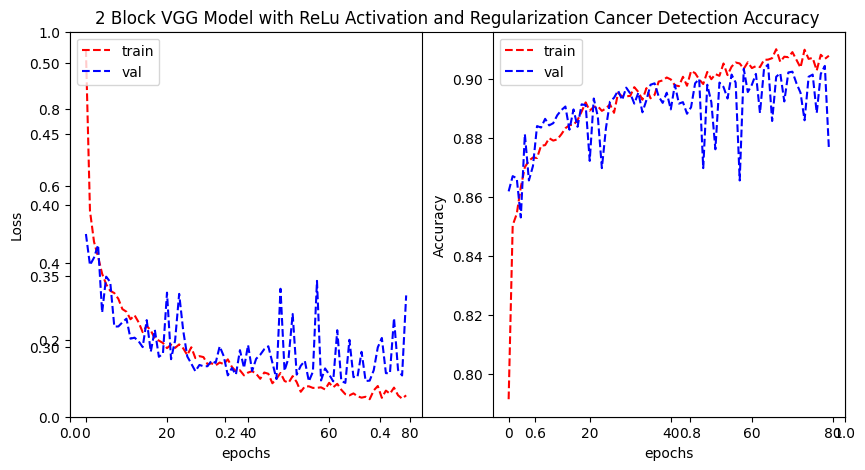

In [72]:
plot_learning_curve("2 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous_best.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.9121 - loss: 0.2559


[0.2659702003002167, 0.9055719971656799]

This very clearly has worked so now we can try to add back the other hidden block and see if the model can handle it now or if it still is too complex for the task. Even though there is still overfitting, it is significantly reduced allowing the model to continue to grow much futher

In [74]:

model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [ ]:
model_VGG_cancerous.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [76]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - categorical_accuracy: 0.6526 - loss: 0.7724 - val_categorical_accuracy: 0.6573 - val_loss: 0.6544
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6519 - loss: 0.6514 - val_categorical_accuracy: 0.6573 - val_loss: 0.6456
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6538 - loss: 0.6493 - val_categorical_accuracy: 0.6573 - val_loss: 0.6450
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6459 - loss: 0.6532 - val_categorical_accuracy: 0.6573 - val_loss: 0.6444
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6485 - loss: 0.6503 - val_categorical_accuracy: 0.6573 - val_loss: 0.6432
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6494 - loss: 0.6503 - val_categorical_accuracy: 0.6573 - val_loss: 0.6505
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy

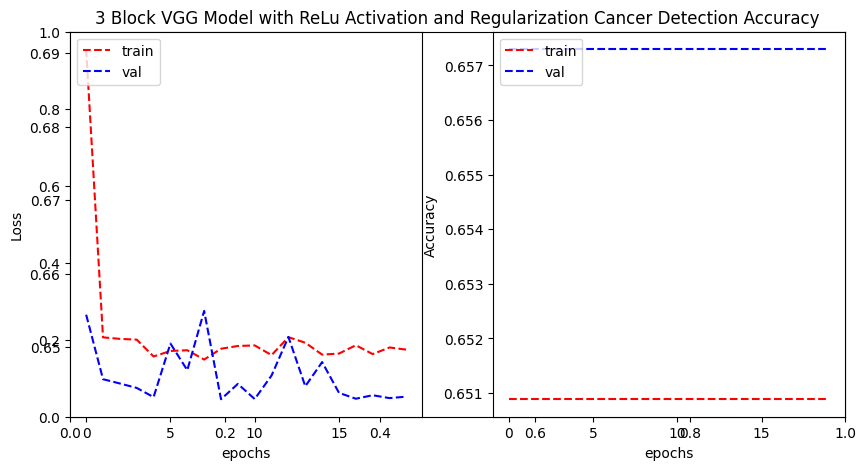

In [77]:
plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [78]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.6444 - loss: 0.6509


[0.649284839630127, 0.6471893787384033]

This very clearly did not work as the model is not fitting at all with the accuracy never changing and the loss being all over the place. The 2 block model seems to be ideal and after all the changes we made the overfitting is not too bad either

Overall CNN was much better with the best models being just over 90% accuracte with a loss of around 25% which is quite good. Even though the models are more complex they do not take that much longer to train than the MLP, the CNN models are quanitfiably more accurate with less loss so there really is no reason not to use them. They also scaled better on more CPU cores than the MLP model which could indicate that they might be faster to train using high core CPUs. Unfortunately GPU support for tensorflow on windows no longer exists with the newer versions of tensorflow so we could not test how they scale on GPUs but if the CPU usage is anything to go by the CNN difference in time between the CNN and the MLP models might become trivial if GPUs were used to train instead of CPUs

**Clasification**

In [156]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
print(data_type)

      InstanceID  patientID  ImageName  cellType
0          22405          1  22405.png         0
1          22406          1  22406.png         0
2          22407          1  22407.png         0
3          22408          1  22408.png         0
4          22409          1  22409.png         0
...          ...        ...        ...       ...
9891        1625         60   1625.png         2
9892        1626         60   1626.png         2
9893        1627         60   1627.png         2
9894        1628         60   1628.png         2
9895        1629         60   1629.png         2

[9896 rows x 4 columns]


In [157]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [158]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [159]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


MLP

In [160]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [161]:
model_classification.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [162]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.4037 - loss: 1.4270 - val_categorical_accuracy: 0.5538 - val_loss: 1.1060
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.5284 - loss: 1.1120 - val_categorical_accuracy: 0.6488 - val_loss: 0.9276
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.5765 - loss: 1.0222 - val_categorical_accuracy: 0.6680 - val_loss: 0.8885
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6067 - loss: 0.9710 - val_categorical_accuracy: 0.5882 - val_loss: 0.9526
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6411 - loss: 0.8829 - val_categorical_accuracy: 0.6064 - val_loss: 0.9061
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6503 - loss: 0.8670 - val_categorical_accuracy: 0.6928 - val_loss: 0.8125
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6575 - l

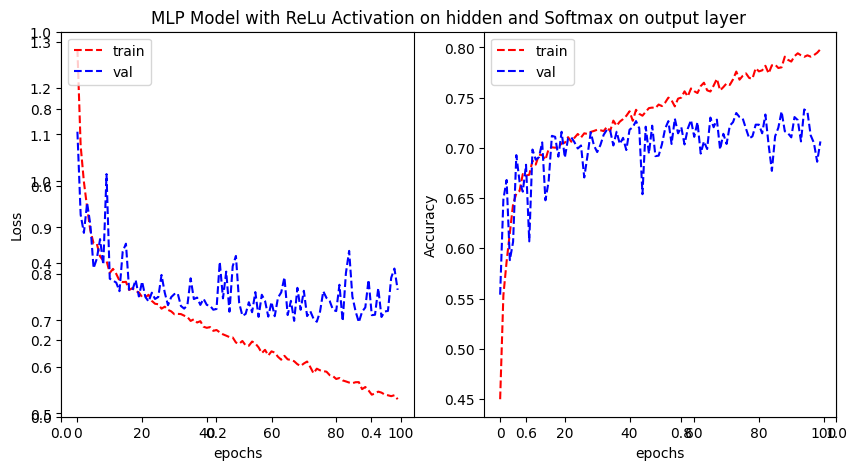

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - categorical_accuracy: 0.7218 - loss: 0.7605


[0.7451299428939819, 0.7207070589065552]

In [163]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

It is a decent start with the model reaching a decent accuracy for a more complex problem, however it has quite a high loss which can be improved upon. We can try adding complexity to the model with more layers to try to better fit the more complex classifer

In [164]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [165]:
model_classification.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [166]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.4550 - loss: 1.2555 - val_categorical_accuracy: 0.6246 - val_loss: 1.1066
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.5256 - loss: 1.1257 - val_categorical_accuracy: 0.4917 - val_loss: 1.1612
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.5665 - loss: 1.0359 - val_categorical_accuracy: 0.5831 - val_loss: 1.0556
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6283 - loss: 0.9453 - val_categorical_accuracy: 0.6261 - val_loss: 0.9571
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6133 - loss: 0.9389 - val_categorical_accuracy: 0.6716 - val_loss: 0.8767
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.6386 - loss: 0.9001 - val_categorical_accuracy: 0.6579 - val_loss: 0.8516
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy

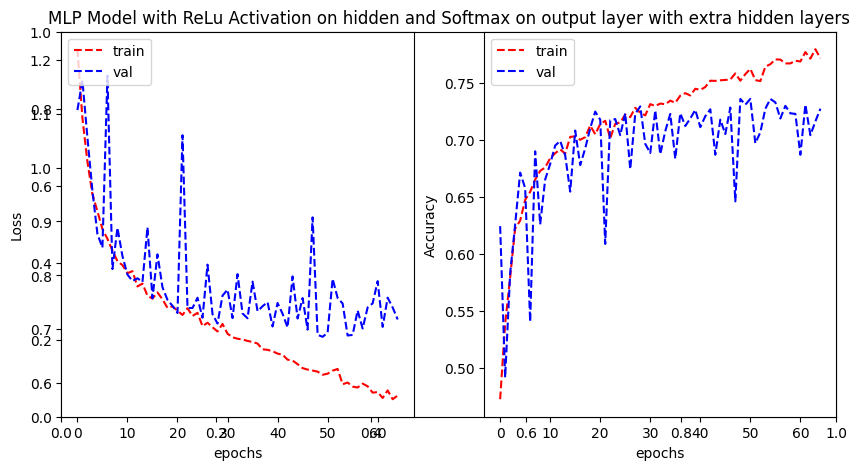

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - categorical_accuracy: 0.7355 - loss: 0.7038


[0.7236543893814087, 0.7227272987365723]

In [167]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with extra hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

The loss is a little improved so we can add even more hidden layers to see if that improves either the loss or the accuracy

In [ ]:
model_classification_best = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [ ]:
model_classification_best.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
history_classification = model_classification_best.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_accuracy: 0.4305 - loss: 1.2756 - val_categorical_accuracy: 0.4775 - val_loss: 1.1644
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.5320 - loss: 1.1200 - val_categorical_accuracy: 0.6165 - val_loss: 0.9375
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.5857 - loss: 1.0174 - val_categorical_accuracy: 0.6503 - val_loss: 0.8695
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6299 - loss: 0.9407 - val_categorical_accuracy: 0.6913 - val_loss: 0.8342
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.6518 - loss: 0.8849 - val_categorical_accuracy: 0.6427 - val_loss: 0.9061
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6406 - loss: 0.8993 - val_categorical_accuracy: 0.6079 - val_loss: 0.9342
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy

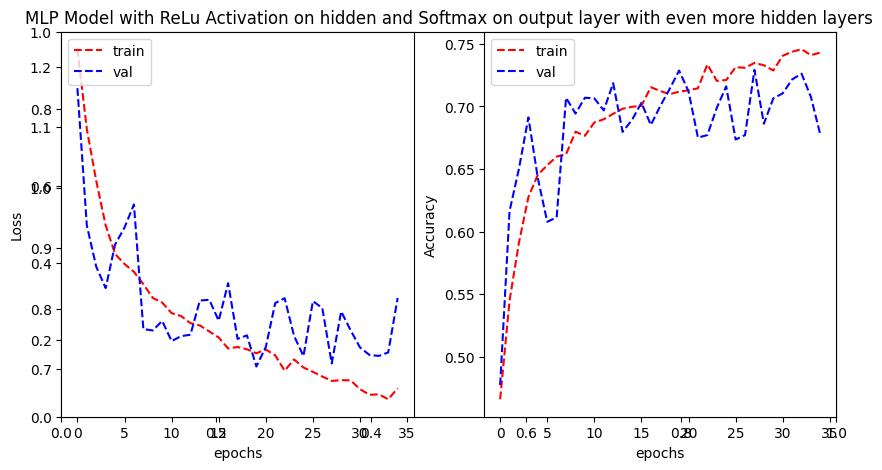

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.7177 - loss: 0.7350


[0.7332314848899841, 0.7121211886405945]

In [ ]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with even more hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification_best.evaluate(test_generator)

The accuracy is similar to the 3 layer NN however the loss is slightly higher and it appears to be overfitting plus it takes longer to train so the extra layer did not help but made the model worse. Here we can use our augmented dataset to try to reduce the overfitting from earlier

In [145]:
train_data_type_augment, test_data_type_augment = train_test_split(mainDataWithAugments, test_size=0.2, random_state=42)
train_data_type_augment, val_data_type_augment = train_test_split(train_data_type_augment, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [146]:
train_data_type_augment['cellType'] = train_data_type_augment['cellType'].astype('str')
val_data_type_augment['cellType'] = val_data_type_augment['cellType'].astype('str')

train_datagen_augment = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_augment = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_augment = train_datagen_augment.flow_from_dataframe(
        dataframe=train_data_type_augment,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_augment = val_datagen_augment.flow_from_dataframe(
        dataframe=val_data_type_augment,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 9789 validated image filenames belonging to 4 classes.
Found 3263 validated image filenames belonging to 4 classes.


In [147]:
test_data_type_augment['cellType'] = test_data_type_augment['cellType'].astype('str')

test_datagen_augment = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_augment = test_datagen_augment.flow_from_dataframe(
        dataframe=test_data_type_augment,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 3264 validated image filenames belonging to 4 classes.


In [148]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [149]:
model_classification.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [150]:
history_classification = model_classification.fit(train_generator_augment, validation_data = validation_generator_augment, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - categorical_accuracy: 0.3429 - loss: 1.3351 - val_categorical_accuracy: 0.3831 - val_loss: 1.3307
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.4759 - loss: 1.1597 - val_categorical_accuracy: 0.4006 - val_loss: 1.2884
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.5114 - loss: 1.0925 - val_categorical_accuracy: 0.6037 - val_loss: 0.9640
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.5496 - loss: 1.0207 - val_categorical_accuracy: 0.6083 - val_loss: 0.9174
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.5712 - loss: 0.9802 - val_categorical_accuracy: 0.6031 - val_loss: 0.9219
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.5684 - loss: 0.9753 - val_categorical_accuracy: 0.5749 - val_loss: 0.9437
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - categorical_accuracy: 0.5914 - 

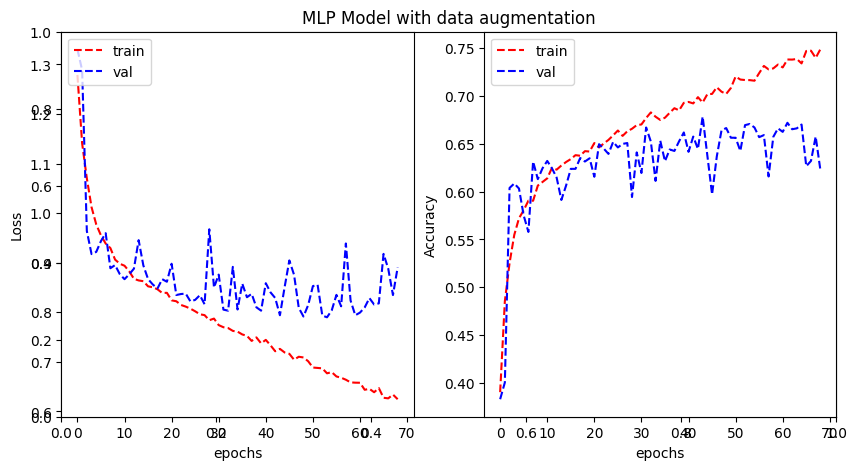

3264/3264 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - categorical_accuracy: 0.6602 - loss: 0.7845


[0.786173403263092, 0.6617646813392639]

In [151]:
plot_learning_curve("MLP Model with data augmentation", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator_augment)

Augmentation made the model worse so we will not be using it moving forward. We can add regularisation to reduce overfitting

In [172]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [173]:
model_classification.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [174]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_accuracy: 0.4344 - loss: 2.6143 - val_categorical_accuracy: 0.4103 - val_loss: 2.6834
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.5349 - loss: 2.4609 - val_categorical_accuracy: 0.6362 - val_loss: 2.3055
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.5907 - loss: 2.3477 - val_categorical_accuracy: 0.6453 - val_loss: 2.1895
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6025 - loss: 2.2999 - val_categorical_accuracy: 0.6751 - val_loss: 2.1603
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6305 - loss: 2.2261 - val_categorical_accuracy: 0.6761 - val_loss: 2.1271
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6481 - loss: 2.1861 - val_categorical_accuracy: 0.6246 - val_loss: 2.2005
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy

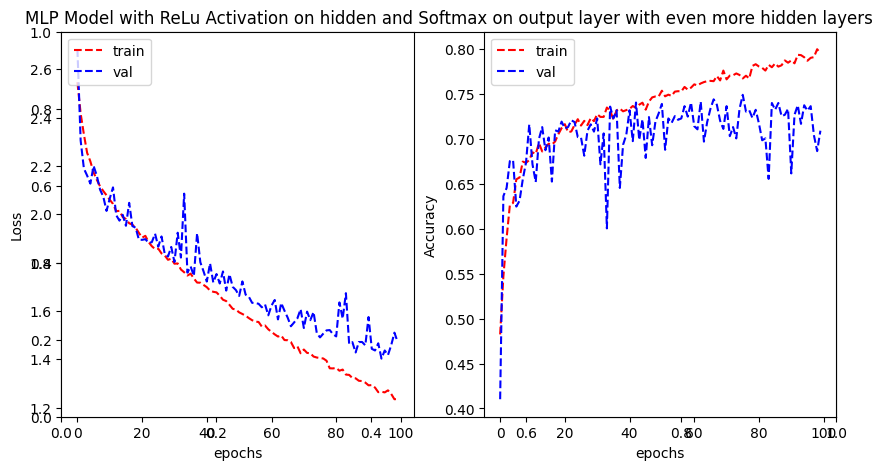

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.7073 - loss: 1.4466


[1.4619030952453613, 0.7101010084152222]

In [175]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with even more hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

The accuracy is relatively similar with overfitting still being an issue but the loss is a lot higher so it was not an improvement. The best model is still the 3 hidden layer model

This problem is much more complicated than the previous one and as such a MLP model is simply not enough to deal with the complexity, once again a CNN is preferable which aligns with what the research paper used

CNN

In [176]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [177]:
model_VGG_1_relu.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [178]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.3991 - loss: 1.3173 - val_categorical_accuracy: 0.4093 - val_loss: 1.2886
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.4421 - loss: 1.2636 - val_categorical_accuracy: 0.5407 - val_loss: 1.1844
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.4857 - loss: 1.2017 - val_categorical_accuracy: 0.4426 - val_loss: 1.2935
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.5701 - loss: 1.0655 - val_categorical_accuracy: 0.6225 - val_loss: 0.9620
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.6203 - loss: 0.9670 - val_categorical_accuracy: 0.6822 - val_loss: 0.8313
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6478 - loss: 0.9077 - val_categorical_accuracy: 0.6726 - val_loss: 0.8496
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy

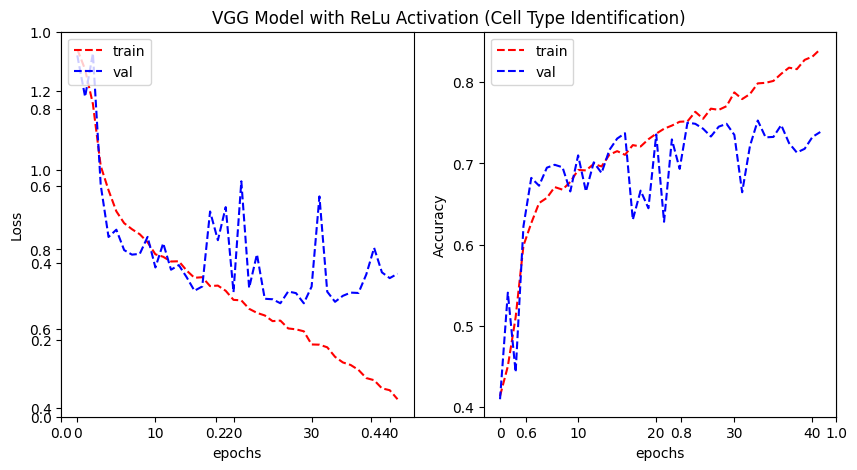

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.7359 - loss: 0.6813


[0.6923156976699829, 0.728787899017334]

In [179]:
plot_learning_curve("VGG Model with ReLu Activation (Cell Type Identification)",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)

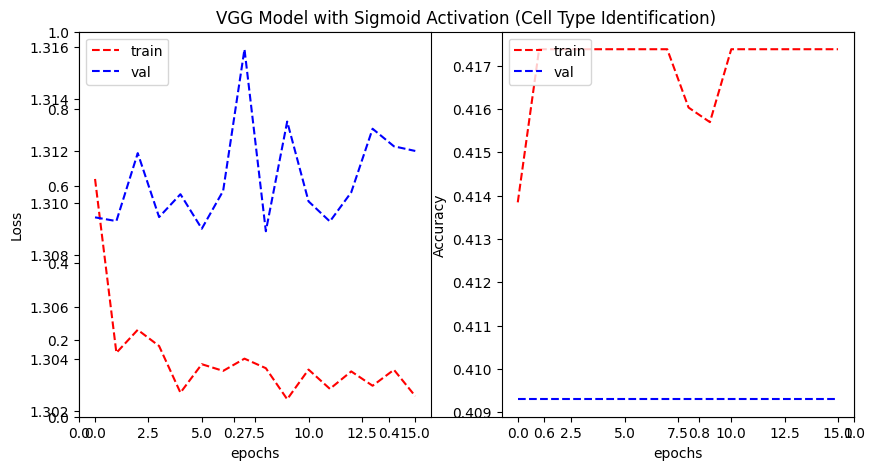

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.3994 - loss: 1.3223


[1.3210736513137817, 0.3994949460029602]

In [180]:
plot_learning_curve("VGG Model with Sigmoid Activation (Cell Type Identification)",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)

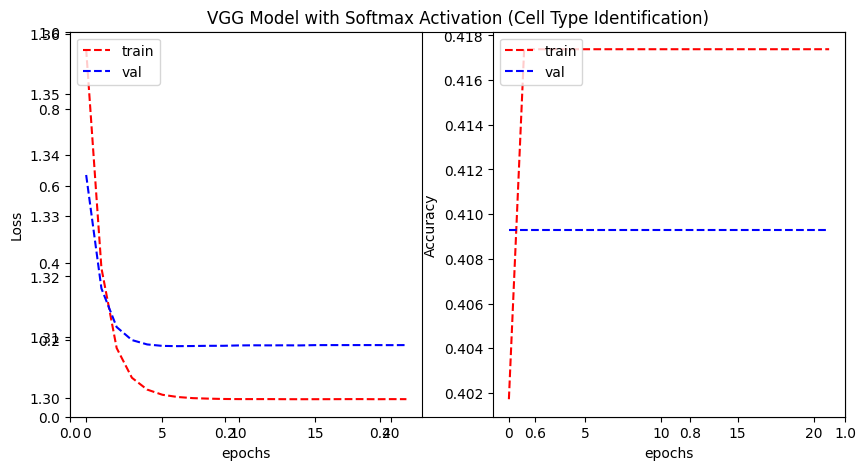

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.3928 - loss: 1.3260


[1.3212851285934448, 0.3994949460029602]

In [181]:

plot_learning_curve("VGG Model with Softmax Activation (Cell Type Identification)",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)


ReLu and Sigmoid both show overfitting with relu being the better of the 2 and softmax as expected has the same issue of not working for hidden layers. We can mix the methods with softmax being the output layer and relu for the hidden layers

In [ ]:
model_VGG_best = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_VGG_best.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG = model_VGG_best.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.4232 - loss: 1.3186 - val_categorical_accuracy: 0.4093 - val_loss: 1.3020
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.4187 - loss: 1.2768 - val_categorical_accuracy: 0.3072 - val_loss: 1.3679
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.4583 - loss: 1.2229 - val_categorical_accuracy: 0.5280 - val_loss: 1.0774
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.5501 - loss: 1.1088 - val_categorical_accuracy: 0.6266 - val_loss: 0.9893
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.5957 - loss: 1.0108 - val_categorical_accuracy: 0.6695 - val_loss: 0.8650
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6230 - loss: 0.9333 - val_categorical_accuracy: 0.6230 - val_loss: 0.8898
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6309 - l

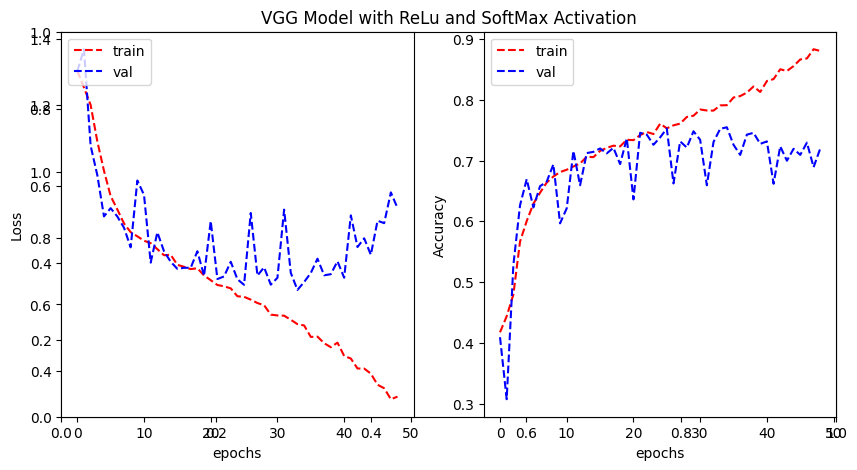

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.7374 - loss: 0.6604


[0.6944285035133362, 0.7303030490875244]

In [ ]:
plot_learning_curve("VGG Model with ReLu and SoftMax Activation",history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['categorical_accuracy'], history_VGG.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_best.evaluate(test_generator)

The accuracy and loss are a little better but overfitting is still clear we can try using the augmented data and regularisation to try to combat this

In [196]:
model_VGG = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [197]:
model_VGG.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [198]:
history_VGG = model_VGG.fit(train_generator_augment, validation_data = validation_generator_augment, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.2734 - loss: 1.3801 - val_categorical_accuracy: 0.3509 - val_loss: 1.3230
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.3777 - loss: 1.3175 - val_categorical_accuracy: 0.5124 - val_loss: 1.1787
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.4644 - loss: 1.2093 - val_categorical_accuracy: 0.5354 - val_loss: 1.0714
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.5229 - loss: 1.0742 - val_categorical_accuracy: 0.4879 - val_loss: 1.1792
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.5588 - loss: 1.0046 - val_categorical_accuracy: 0.5961 - val_loss: 0.9271
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.5840 - loss: 0.9536 - val_categorical_accuracy: 0.5624 - val_loss: 0.9527
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy

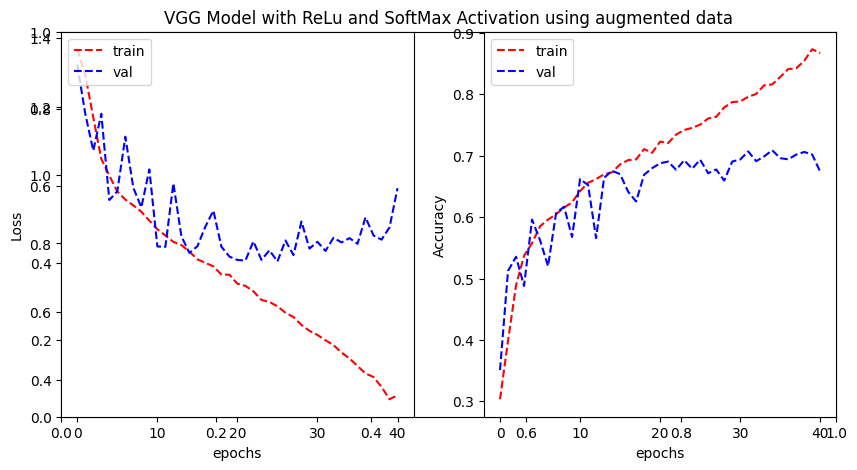

3264/3264 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - categorical_accuracy: 0.6862 - loss: 0.7765


[0.755262017250061, 0.6865808963775635]

In [199]:
plot_learning_curve("VGG Model with ReLu and SoftMax Activation using augmented data",history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['categorical_accuracy'], history_VGG.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG.evaluate(test_generator_augment)



In [200]:
model_VGG = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [201]:
model_VGG.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [202]:
history_VGG = model_VGG.fit(train_generator_augment, validation_data = validation_generator_augment, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.3235 - loss: 1.5156 - val_categorical_accuracy: 0.5020 - val_loss: 1.4239
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.4080 - loss: 1.4301 - val_categorical_accuracy: 0.4857 - val_loss: 1.3429
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.4879 - loss: 1.3087 - val_categorical_accuracy: 0.5642 - val_loss: 1.1467
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.5256 - loss: 1.2195 - val_categorical_accuracy: 0.5458 - val_loss: 1.1364
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.5493 - loss: 1.1755 - val_categorical_accuracy: 0.5504 - val_loss: 1.1396
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.5793 - loss: 1.0900 - val_categorical_accuracy: 0.5765 - val_loss: 1.1183
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy

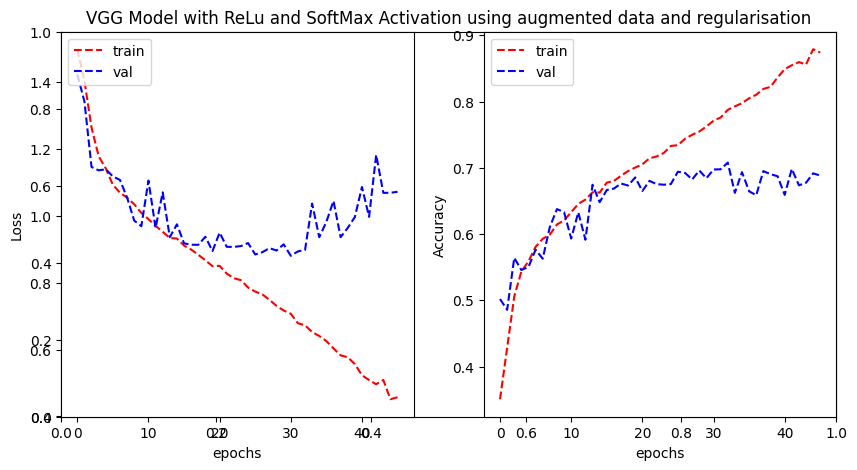

3264/3264 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - categorical_accuracy: 0.6994 - loss: 0.8580


[0.8855999708175659, 0.6850489974021912]

In [203]:
plot_learning_curve("VGG Model with ReLu and SoftMax Activation using augmented data and regularisation",history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['categorical_accuracy'], history_VGG.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG.evaluate(test_generator_augment)



The models did not improve but became worse after doing both regularisation and augmented data

That means our best model was the one with just relu for the hidden layers and softmax for the output layer with no augmentation nor regularisation

In [ ]:
#Using extra data to  improve the cell type classification
extra_data_for_type = data_extra[["InstanceID", "patientID", "ImageName"]]

def preprocess_image(filename, img_dir="./patch_images/"):
    path = os.path.join(img_dir, filename)
    image = Image.open(path).convert("RGB")
    image = image.resize((27, 27))
    image_array = np.array(image).astype(np.float32) / 255.0
    return image_array

X_extra = np.array([
    preprocess_image(name) for name in extra_data_for_type["ImageName"]
])

predictions = model_VGG.predict(X_extra)
predicted_classes = np.argmax(predictions, axis=1)

label_dict = {0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'other'}
predicted_labels = [label_dict[i] for i in predicted_classes]

extra_data_for_type["predicted_cellType"] = predicted_labels

extra_data_for_type.to_csv("extra_data_with_predictions.csv", index=False)

In [ ]:
extra_data_with_predictions = pd.read_csv("extra_data_with_predictions.csv")
extra_data_with_predictions["isCancerous"] = data_extra["isCancerous"]
print(extra_data_with_predictions)
print(data_main)

reverse_dict = {v: k for k, v in label_dict.items()}
newData = pd.concat([data_main, extra_data_with_predictions])
newData["cellTypeName" ] = newData["cellTypeName"].fillna(newData["predicted_cellType"])
newData["cellType"] = newData["cellType"].fillna(newData["cellTypeName"].map(reverse_dict))
newData = newData.drop(columns=["predicted_cellType"])

print(newData) 
col = "predicted_cellType"
value_counts = extra_data_with_predictions[col].value_counts()
for value, amount in extra_data_with_predictions[col].value_counts().items():
    print(str(value).capitalize() + ": " + str((amount/len(extra_data_with_predictions[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.axis('equal')  
    plt.show()
print(data_extra["isCancerous"].value_counts())
print(value_counts)


**Comparison**


**Paper: Detection and Classification of Cells in Colorectal Histology Images Utilizing U-Net Machine Learning Architecture - Quinn Gatesa , Mohamed Allaliab, Chloe Martin-Kinga(1)**


In this paper, the research team proposed a method for cell classification using the “unique advantages of the U-Net neural network architecture”. The U-net neural network architecture refers to the method behind the segmentation of cell from an image. Their classification model, (like ours) used a convolutional neural network. Their model mimicked the proposed model in the paper “RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification” (2), in which it was organised into 3 blocks containing two convolutional layers and a pooling layer. As part of their preprocessing, they also decided to use data augmentation, generating variants which were horizontally flipped, vertically and horizontally shifted, and with rotations of up to 45 degrees. This contrasts our augmentation algorithm which flipped both horizontally and vertically and only had rotations of up to 20 degrees. This slight difference in the augmentation process and also when it occurred (in the image generator vs. adding to the initial dataset) may be responsible for their increased performance over our model. While our best model using augmentation had an accuracy of 69.94%, theirs outperformance with 78.3%. Our VGG Model with ReLu and SoftMax activation also falls slightly behind at 73.7% accuracy. While the comparison shows both their U-Net model outperforming our own, the evaluation is not entirely valid as there are certain strategies that could not be replicated given our requirements. The most important being the augmentation. Due to researchers having the ability to segment the data using their own techniques, our images were pre segmented for us. Meaning, horizontal and vertical shifting was not possible. 

(1)  Gates, Quinn D. and Allali, Mohamed and Martin-King, Chloe, Detection and Classification of Cells in Colorectal Histology Images Utilizing U-Net Machine Learning Architecture. Available at SSRN: https://ssrn.com/abstract=3981501 or http://dx.doi.org/10.2139/ssrn.3981501


(2) S. H. Shabbeer Basha, S. Ghosh, K. Kishan Babu, S. Ram Dubey, V. Pulabaigari and S. Mukherjee, "RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification," 2018 15th International Conference on Control, Automation, Robotics and Vision (ICARCV), Singapore, 2018, pp. 1222-1227, doi: 10.1109/ICARCV.2018.8581147. keywords: {Cancer;Computer architecture;Colon;Biomedical imaging;Task analysis;Training;Image analysis},




**Generating Cell Type for Unmarked data (extra data)**
As part of our testing, we used the unlabeled data as an input into our best performing classification model. While the data is unlabeled and thus we can’t quantitatively determine its performance, we can analyse the shape and distribution of the data in a similar way to our EDA process. Out of the 10,384 cells in the unlabeled dataset, 4,390 were identified as epithelial (42.3%), 4861 as inflammatory (46.8%), 905 as fibroblast (8.7%) and the remaining 228 as other (2.2%). This distribution lines up fairly similarly to the main data’s distribution, which can be a good indicator of the performance. However, the reason why this data is unlabeled is unknown and it may not truly share the same distribution. This is further proven by the distribution of isCancerous that we analysed earlier in the report.


***APPENDIX*** --------

**Discussion on Semi-Supervised Learning**
Semi-supervised learning is a branch of machine learning that uses both labelled and unlabeled data to train AI model for classification. Generally, semi-supervised learning methods are used when labeled data is valuable but obtaining it can be expensive, difficult or time consuming.
In the context of our dataset, we have 9897 entries of labeled data, a subset of the original datasets 22,444 labeled entries , which was annotated by an experienced pathologist and also a graduate student under supervision by the same pathologist. The remaining data was not labeled. With both datasets, it would be possible to build a semi-supervised model by using a self-training technique which retrains the classification model by feeding it our predicted “pseudo-labeled” extra data. 
Semi-supervised models are an effective way to get the most out of a limited amount of labeled data, though as much as they benefit from self training, they are quite sensitive to the quality of the input data, and given a small enough sample size may make incorrect assumptions about presented data. While this would not be an issue in our dataset, higher dimensionality can be difficult for semi-supervised models to precisely predict. 

An area where semi-supervised learning can be very effective is with online media. It's estimated that there are hundreds of millions of recorded audio on the internet, of which only a small percentage is labeled. Speech and image recognition models are able to become extremely accurate and precise due to semi-supervised learning approaches which take advantage of the abundance of data. Auto-generated closed captions and transcripts only exist at the quality they do because of self-learning semi-supervised models. Without using this unlabeled data, the amount available is much lower, resulting in a model that would not continually get better.

**Data Augmentation**:
Because data augmentation provides a larger dataset for our models to train off of, it is expected that generally it should result in a higher accuracy and less overfitting. However, as demonstrated in our classification section, data augmentation only made it perform worse. There are a couple of reasons as to why this outcome may have occurred. 
1. Poor quality augmentation 
	If the augmented images were manipulated in a way that removed the recognisable key features of the cell, the model may prefer insignificant features. If the dataset was oriented in a certain way that ensured all cells were aligned in the same fashion, horizontal and vertical flips as well as any degree of rotation may have damaged the relationship between the image and its classification.
2. Class Distribution Drift
By augmenting only the underrepresented classes, their unique features may become more significant to the model, resulting in rarer classes and features becoming overpredicted. This could have been avoided in a few different ways: Using class weights when training the model would mean that the data would not be changed; Instead of creating more data for the model, we could have downsampled, reducing the amount of overrepresented samples and reducing the total amount; Better choice of when to augment data; by augmenting the data we are using for our test train split, we are also augmenting our test and validation data, which should only include real samples.

**Model accuracy and consistency:**
The isCancerous models were much more consistent and predictable, with the results changing as expected with each modification in a small, easy to follow way. On the other hand the cell type classifier was much harder to work with, not only having a much lower accuracy and higher loss but also the methods commonly used to reduce overfitting made the model worse as well as both adding and removing complexity making the model worse so there was not as much to build on and improve in small steps like with the cancer classifier.
